In [1]:
import os,sys
sys.path.append('/Users/nxroth/scripts')
from glob import glob
import astropy.units as u
import numpy as np
from jwstComet import extraction, modeling, utils

In [2]:
#Find the JWST cube file
#Here we use JWST NIRSpec IFU G395M/F270LP observations of comet C/2017 K2 (PanSTARRS)
#Reported in Woodward et al. 2025, PSJ, 6, 139
#Cube downloaded from the STScI MAST archive
files = glob('../*s3d.fits')
print('Found the following cubes: {}'.format(files))

#Comet Name
cometName = 'C/2017 K2'

#Set the lower and upper wavelengths (microns)
waveLo = 3.255*u.um
waveUp = 3.328*u.um


#Get the pixel size from the data cube, first reading in the file
sciCube = utils.readCube(files[0])
#Solid angle subtended by a square pixel (steradians)
psr = sciCube.hdr['PIXAR_SR']*u.sr
#Convert to pixel side length in arcseconds
psa = np.sqrt(psr.to(u.arcsec**2))
#Set aperture width as a given number of pixels
#radAp = 5*psa
#Instead set a circular aperture based on a given angular size
radAp = 1.5*u.arcsec/2
print('Radius aperture = {}'.format(radAp))

#Instead set a rectangular aperture size
#radAp = [0.5,0.5]*u.arcsec

#Set the extraction mode: options are 'circle' or 'rectangle'
mode = 'circle'

#Set x and y offsets from the photocenter for the extract
xOffset = 0*u.arcsec
yOffset = 0*u.arcsec

#Do we want fresh modeling runs (True), or are we reading previous results (False)?
run_ret = True

Found the following cubes: ['../jw01566-o018_t006_nirspec_g395m-f290lp_s3d.fits']
Radius aperture = 0.75 arcsec


In [3]:
if run_ret:
    #Clear out old extracted spectra, retrieval, or configuration files sitting around
    os.system('rm -rf *txt')
    os.system('rm -rf *cfg*')

In [4]:
#Set up the dictionaries for coma composition and retrieval parameters

#Dictionary to describe the coma. Preserve this order for keys: [1] Solar Activity, [2] Temperature, [3,4,...,n] Coma Gases
coma_dict = {
    'Solar Activity': 'active',  #Choose 'active' or 'quiet' based on solar cycle during data collection
    'COMA-ACTIVITY': {'value': 7.6e28, 'unit': 'gas'},  #Set a value for the overall molecular production rate (usually H2O). PSG uses 'gas' for units of s^-1. Here we use the value from Woodward et al. 2025, PSJ, 6, 139
    'TEMPERATURE': {'value': 40, 'unit': 'K'},  #Set the coma temperature
    'SURFACE-GAS-RATIO': {'value': 1, 'unit': 'ratio'}, #Parameters for the continuum model. If wantCont = False, no physical continuum model will be used
    'SURFACE-ALBEDO': {'value': 0.04},
    'SURFACE-EMISSIVITY': {'value': 0.90},
    'SURFACE-TEMPERATURE': {'value': 138},
    'DIAMETER': {'value': 4},
    'ATMOSPHERE-WEIGHT': {'value': 310, 'set': True}, #Optionally set the gas expansion speed in units of m/s. If not set, will use the default PSG estimate

    #Now we start setting the abundances of gases to include in the model (percent)
    #Note that any molecule you want to retrieve must be in this dictionary as well.
    'H2O': {'value': 100, 'unit': 'pct'},
    'OHP': {'value': 100, 'unit': 'pct'},
    'CH4': {'value': 0.8, 'unit': 'pct'}
}

retrieval_options = {
    'GAMMA': 1.0,    #regularization parameter, see https://psg.gsfc.nasa.gov/helpmodel.php#retrieval. 1.0 is good for us.
    'FLUXSCALER': 1.0, #Data scaling factor. None should be needed for calibrated JWST data
    'FITTELLURIC': 'N',  #Should we fit a telluric model? (No, we're in space without an atmosphere)
    'FITGAIN': -1,       #Should we fit a gain curve? (No, our data are well calibrated)
    'FITGAIN-PHOTOMETRIC': 'Y',  #If we do fit a gain curve, should it be photometric?
    'REMOVEOFFSET': '2',  # Degree of a polynomial to fit for spectral baseline (I like 2nd degree)
    'REMOVEFRINGE': 0,   #Should we remove any fringes? (I usually say no)
    'FITSTELLAR': 'N',    #Should we fit any stellar features in the spectra?
    'FITFREQ': 'Y',       #Should we adjust the frequency to account for any offsets?
    'COMA-OPACITY': 'thick', #Should we circumvent the PSG opacity correction?
    'SCALE-SIGMAS': 'Y', #Should we scale the sigmas with chisq?
    'RP-type': 'RP' #Various options for setting spectral resolving power. Can choose 'RP-type' with 'RP' or 'dispersion' to use values from STScI-provided dispersion vs. wavelength curves
    #'RP': {'res_element': 1.320, 'res_type': 'nm'} #Alternatively, set the spectral resolution to a manual value
    #'RP-list': 'Y' #Finally, may consider an empirically determined set of RP's (for NIRSpec) provided by G. Villanueva
}

retrieval_dict = {
    #Now we start setting the retrieval parameters.
    #This requires minimum and maximum allowed values, a guess, and a unit
    #For coma activity, use 'gas'. For abundances, use 'pct'.
    #For gases, use 'COMA-gasname[modelname]'
    #See NASA PSG documentation, or run a retrieval yourself using the web interface at psg.gsfc.nasa.gov
    #and download the configuration file to see which keys are required for a given molecule.
    #Here we retrieve the CH4 molecular abundance and rotational temperature
    'COMA-TEMPERATURE': {'min': 1, 'max': 80, 'start': 40, 'unit': 'K'},
    'COMA-CH4[CH4]': {'min': 0.01, 'max': 5, 'start': 0.8, 'unit': 'pct'},

}

Center coordinates are (29,25)


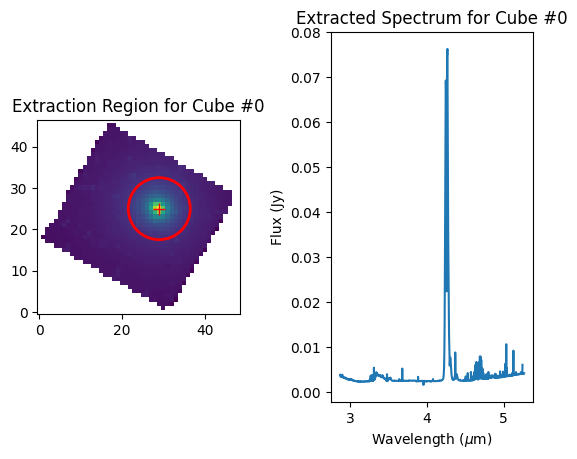

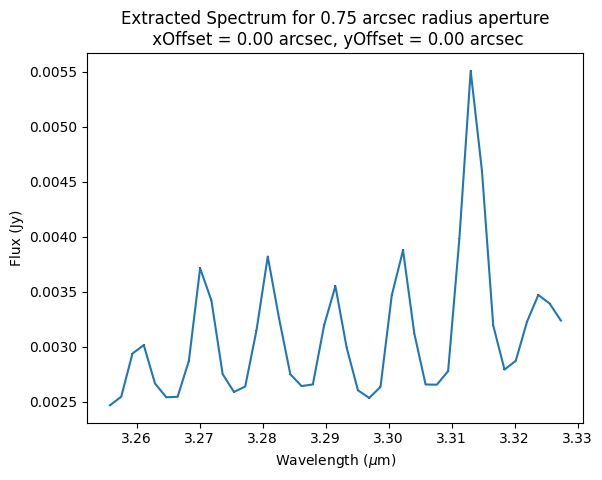

2022-Aug-21 21:27:50.752


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1793    0  1664  100   129   1862    144 --:--:-- --:--:-- --:--:--  2007
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Using STScI RP/dispersion lookup table
832.1376214178995 RP


100  6132    0     0  100  6132      0   5117  0:00:01  0:00:01 --:--:--  5118

Band sum = 2.232e-02


100  210k    0  204k  100  6132   140k   4211  0:00:01  0:00:01 --:--:--  144k


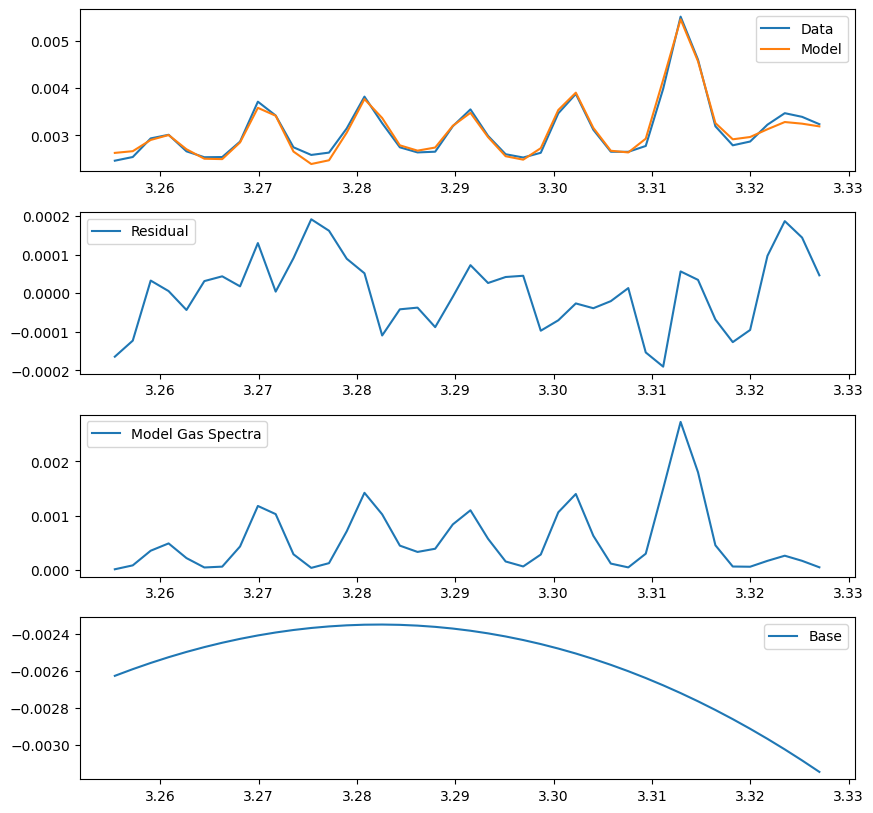

COMA-TEMPERATURE = 4.3500e+01 +- 9.5186e-01
COMA-CH4[CH4]
 = 8.7259e-01
 +- 2.6726e-02



In [5]:
#Now run new retrievals if requested
local=False #set to False for a locally installed version of PSG, or True to use the psg.gsfc.nasa.gov server
withCont=False #set to False to prevent a thermal emission continuum model being used (i.e., simply fit a baseline)
masterATM=False #Optionally provide the PSG with a pre-filled atmosphere template
masterATMFile=None #If using a pre-filled template, provide the path
withPlots = True #Include output plots
if run_ret:
    #Extract and construct a radial profile
    #Arrays to hold the retrieved variables, values, and sigmas
    retrieval_variables = []
    retrieval_values    = []
    retrieval_sigmas    = []

    #Name for our extracted spectrum
    specFile = 'JWST-Extract-{:.2f}-arcsecRadius-{:.2f}-arcsecXoffset-{:.2f}-arcsecYoffset-{:.2f}um-to-{:.2f}um.txt'.format(radAp.value,xOffset.value,yOffset.value,waveLo.value,waveUp.value)
    #Initialize the extraction routine
    beam = extraction.Beam()
    #Extract the spectrum
    beamExtract = beam.extractSpec(cubeFiles=files, specFile=specFile, waveLo=waveLo, waveUp=waveUp, 
                                   radAp=radAp, xOffset=xOffset, yOffset=yOffset, withPlots=True)
    #Initialize the modeling routine
    beamModel = modeling.runPSG()
    
    #Name of file where our model results are saved
    resFile = specFile[:-3]+'retrieval-results.txt'
    
    #Send the data to the PSG for the requested coma model and/or retrieval
    beamModel.getModels(specFile=specFile, resFile=resFile, name=cometName, objectType='Comet', composition=coma_dict, 
                        retrieval_options=retrieval_options, retrieval=retrieval_dict, mode=mode, withCont=withCont, 
                        withPlots=withPlots, local=local, masterATM=masterATM, masterATMFile=masterATMFile)
    results = modeling.readPSG(resFile)

In [6]:
#Interact with the retrieved values
print(results.retrieval_variables)
print(f"T_rot = {results.retrieval_values[0]:.1f} +/- {results.retrieval_sigmas[0]:.1f} K")

['COMA-TEMPERATURE', 'COMA-CH4[CH4]']
T_rot = 43.5 +/- 1.0 K
